In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import sys
import tensorflow as tf
import cv2

mnist_labels = np.load("segmented.npy")
_, HEIGHT, WIDTH, N_CLASSES = mnist_labels.shape
mnist_inputs = np.load("combined.npy").reshape((-1, HEIGHT, WIDTH, 1))/255



Using TensorFlow backend.


In [2]:
# mnist_inputs = mnist_inputs.reshape(5000,64,84)

C:\Users\Buster\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


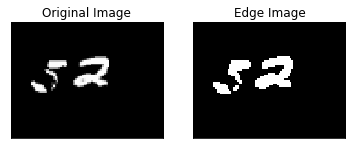

In [3]:
kernel = np.ones((2,2),np.uint8)
for x in mnist_inputs:
    plt.subplot(121),plt.imshow(x.reshape(64,84),cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    x = cv2.dilate(np.round(x.reshape(64,84)).astype('uint8'),kernel,iterations = 1)
    mnist_inputs = np.append(mnist_inputs,x.reshape(1,64,84,1),axis=0)
    plt.subplot(122),plt.imshow(x,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])


In [7]:
inputs=keras.layers.Input((HEIGHT, WIDTH,1))

x=keras.layers.ZeroPadding2D(((0, 0), (0, 96-WIDTH)))(inputs)

layers = []

for n, k, s in [(32, 5, 1),(64, 5, 1),(128, 5, 1),(128, 3, 1),(128, 3, 1)]:
    x=keras.layers.Conv2D(n, kernel_size=k, strides=s, padding='same')(x)
    x=keras.layers.LeakyReLU()(x)
    x=keras.layers.Conv2D(n, kernel_size=k, strides=s, padding='same')(x)
    x=keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x=keras.layers.LeakyReLU()(x)
    x=keras.layers.BatchNormalization()(x)
    layers.append(x)
layers.pop()

for n, k, s in [(128, 3, 1),(128, 3, 1)]:
    x=keras.layers.Conv2D(n, kernel_size=k, strides=s, padding='same')(x)
    x=keras.layers.LeakyReLU()(x)
    x=keras.layers.BatchNormalization()(x)
    
for n, k, s in reversed([(N_CLASSES, 5, 2),(64, 5, 2),(64, 5, 2),(128, 5, 2),(128, 5, 2)]):
    x=keras.layers.Conv2DTranspose(n, kernel_size=k, strides=s, padding='same')(x)
    if len(layers)>0:
        l = layers.pop()
        x=keras.layers.concatenate([l, x])
    x=keras.layers.LeakyReLU()(x)
    x=keras.layers.BatchNormalization()(x)
    
x=keras.layers.Conv2DTranspose(N_CLASSES, kernel_size=5, strides=1, padding='same')(x)
x=keras.layers.Cropping2D(((0, 0), (0, 96-WIDTH)))(x)
outputs = keras.layers.Activation('softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 84, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 64, 96, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 96, 32)   832         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 96, 32)   0           conv2d_1[0][0]                   
_____________________________________

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(rotation_range=10.0,
                                                       width_shift_range=2,
                                                       height_shift_range=2,
                                                       shear_range=0.0,
                                                       zoom_range=0.1,
                                                       data_format='channels_last',
                                                       validation_split=0.1
                                                      )

In [ ]:
# model.compile(loss='categorical_crossentropy',
#               optimizer=keras.optimizers.Adam(0.001),
#               metrics=['accuracy'])

# epochs = 30
# batch_size = 25
# model_name = input("Specify a name for the model to be saved: ")
# model.fit_generator(zip(datagen.flow(mnist_inputs, batch_size=batch_size, subset='training', seed=1), datagen.flow(mnist_labels, batch_size=batch_size, subset='training', seed=1)),
#                     epochs=epochs, 
#                     steps_per_epoch = len(mnist_inputs)//batch_size,
#                     validation_data=zip(datagen.flow(mnist_inputs, batch_size=batch_size, subset='validation', seed=1), datagen.flow(mnist_labels, batch_size=batch_size, subset='validation', seed=1)),
#                     validation_steps=50,
#                     #callbacks=[keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=0, mode='auto')],
#                     verbose=2
#          )

In [ ]:
model.save(model_name)

In [ ]:
model = tf.keras.models.load_model('mnist_segmentation.model')   #Load Model

In [ ]:
N_TEST = 1
SEED = np.random.randint(0, 1000)
originals = next(datagen.flow(mnist_inputs, batch_size=N_TEST, subset='validation', seed=SEED))
ground_truth = next(datagen.flow(mnist_labels, batch_size=N_TEST, subset='validation', seed=SEED))
predicted = model.predict_on_batch(originals)
predicted = np.round(predicted).astype(np.int)
plt.figure(figsize=(20, 5))
np.set_printoptions(threshold=sys.maxsize)
for i in range(N_TEST):
    plt.subplot(4, N_TEST, i+1)
    plt.imshow(originals[i].reshape((HEIGHT, WIDTH)))
    plt.subplot(4, N_TEST, i+1+N_TEST)
    plt.imshow(np.argmax(predicted[i], axis=2), vmax=10, vmin=0)
    plt.subplot(4, N_TEST, i+1+2*N_TEST)
    plt.imshow(np.argmax(ground_truth[i], axis=2), vmax=10, vmin=0)
    plt.subplot(4, N_TEST, i+1+3*N_TEST)
    plt.imshow(np.any(predicted[i]-ground_truth[i], axis=2))
    for j in range(10):
        if (predicted[:,:,:,j].sum(1).sum() >= 50):
            print("Detected a: " + str(j))
        

In [ ]:
# plt.imshow(mnist_inputs[1].reshape(64,84))
plt.figure()
plt.imshow(np.round(mnist_inputs[1].reshape(64,84)).astype('uint8'), cmap='gray')
kernel = np.ones((2,2),np.uint8)
dilation = cv2.dilate(np.round(mnist_inputs[1].reshape(64,84)).astype('uint8'),kernel,iterations = 1)
plt.figure()
plt.imshow(dilation, cmap='gray')

In [ ]:
np.argmax(originals[0],axis=2)

In [ ]:
predicted[:,:,:,3]

In [ ]:
predicted[:,:,:,j].sum(1).sum()

In [ ]:
    for j in range(10):
        if (predicted[:,:,:,j].sum(1).sum() >= 30):
            print("Detected a: " + str(j))

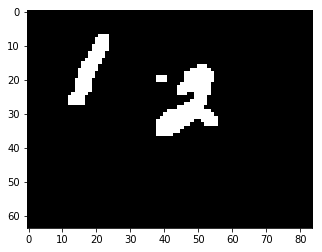

In [6]:
plt.imshow(mnist_inputs[9990].reshape(64,84),cmap='gray')

In [ ]:
.shape

In [ ]:
mnist_inputs.shape